# Constants

In [90]:
IALAB_MEMBER = True
IALAB_USER = 'jiossandon'

# Imports

In [91]:
import os
import sys

In [92]:
if IALAB_MEMBER:
  matterport_build_path = f'/home/{IALAB_USER}/datasets/Matterport3DSimulator/build'
  metadata_script_path = f'/home/{IALAB_USER}/repos/360-visualization/metadata_parser'
  connectivity_path = lambda scan: f'/home/{IALAB_USER}/repos/360-visualization/connectivity/{scan}_connectivity.json'
  instructions_path = f'/home/{IALAB_USER}/storage/objects-auxiliary/paths/R2R_val_unseen.json'
else:
  matterport_build_path = f'/Matterport3DSimulator/build' # Path to simulator
  metadata_script_path = f'/360-visualization/metadata_parser' # Path to metadata parser of this repository
  connectivity_path = lambda scan: f'/connectivity/{scan}_connectivity.json' # Path to graph connectivity json
  instructions_path = f'R2R_val_unseen.json' # Paths data



In [93]:
if matterport_build_path not in sys.path:
    sys.path.append(matterport_build_path)

if metadata_script_path not in sys.path:
    sys.path.append(metadata_script_path)

In [94]:
import sys
import numpy as np
import json

import matplotlib.pyplot as plt
%matplotlib inline

import random
from collections import defaultdict
from utils import (
    visualize_panorama_img, get_viewpoint_region_name, 
    IMG_HEIGHT, IMG_WIDTH, FORBIDDEN_WORDS
)
from objects_and_crafted_instructions_utils import (
    TURN_EXPRESSIONS, MOVE_TO_OBJECT_REFERENCE, MOVE_TO_OTHER_ROOM_WITH_OBJECT,
    MOVE_FROM_REGION_TO_OTHER, WAIT, get_closer_object, get_object_from_viewpoint_orientation,
    get_same_room_instruction, get_final_closer_object, final_object, get_hard_turn,
)

from parse_house_segmentations import HouseSegmentationFile

# Crafted Instructions Generator

In [95]:
# Load vocabulary

path_to_train_vocabulary = f"/home/{IALAB_USER}/storage/speaker_follower_with_objects/tasks/R2R/data/train_vocab.txt"
with open(path_to_train_vocabulary, "r") as file:
    train_vocab = [line.rstrip() for line in file]

In [96]:
# Creats viewpoints information dict

viewpoints_information = defaultdict(dict)

In [97]:
# Function for getting an atomic instruction (for specific action and panorama)

def get_craft_short_instruction(region_name_of_current_viewpoint, viewpoint_heading, viewpoint_info, next_viewpoint, used_objects=[]):
    instrs = []
    best_object = None

    if next_viewpoint:
        hard_turn = get_hard_turn(next_viewpoint['heading'])
        if hard_turn:
            if hard_turn == 'around':
                instrs.append('turn around')
            else:
                instrs.append(random.choice(TURN_EXPRESSIONS)(hard_turn))

        best_object = get_closer_object(viewpoint_info['objects'], next_viewpoint['heading'], next_viewpoint['distance'], used_objects)
        if best_object:
            orientation = get_object_from_viewpoint_orientation(best_object, next_viewpoint)

            # If we do not change the environment just append the object
            if region_name_of_current_viewpoint == next_viewpoint['name']:
                object_phrase = random.choice(MOVE_TO_OBJECT_REFERENCE)(orientation, best_object['name'])
                instrs.append(object_phrase)
            else:
                object_phrase_with_room_change = random.choice(MOVE_TO_OTHER_ROOM_WITH_OBJECT)(region_name_of_current_viewpoint, next_viewpoint['name'], orientation, best_object['name'])
                instrs.append(object_phrase_with_room_change)
        else:
            # If we do not change the environment use instructions on the same environment
            if region_name_of_current_viewpoint == next_viewpoint['name']:
                instruction = get_same_room_instruction(next_viewpoint, hard_turn)
                instrs.append(instruction)
            else:
                phrase_with_room_change = random.choice(MOVE_FROM_REGION_TO_OTHER)(region_name_of_current_viewpoint, next_viewpoint['name'])
                instrs.append(phrase_with_room_change)
    else:
        best_object = get_final_closer_object(viewpoint_info['objects'])
        if best_object:
            instrs.append(final_object(best_object['name'], best_object['orientation']))
        else:
            instrs.append(random.choice(WAIT))

    cleaned_instrs = list(filter(lambda x: len(x) >= 1, instrs))
    return ", ".join(cleaned_instrs), best_object

In [98]:
def get_step_information_and_show_panorama(scan, viewpoint, viewpoint_heading, next_viewpoint, metadata, viewpoints_information, used_objects, visualize=True):
    objects = metadata.angle_relative_viewpoint_objects(viewpoint)

    # Add to post processing data
    viewpoints_information[viewpoint]['objects'] = []
    viewpoints_information[viewpoint]['viewpoints'] = []

    reachable_viewpoints = metadata.angle_relative_reachable_viewpoints(viewpoint, connectivity_path(scan))

    images = []
    for viewpoint_elevation in (np.pi / 2 * x for x in range(-1, 2)):
        im = visualize_panorama_img(scan, viewpoint, viewpoint_heading, viewpoint_elevation)
        images.append(im)

    _, ax = plt.subplots(1,1, figsize=(18,9))

    img = np.concatenate(images[::-1], axis=0)

    ax.imshow(img)
    plt.xticks(np.linspace(0, IMG_WIDTH - 1, 5), [-180, -90, 0, 90, 180])
    plt.xlabel(f'relative heading from the agent. -90° is left, 90° is right, and (-)180° is behind')
    plt.yticks(np.linspace(0, IMG_HEIGHT - 1, 5), [-180, -90, 0, 90, 180])

    next_heading = viewpoint_heading
    x0, y0 = viewpoint_heading, 0

    # Iterate over objects, plot and retrieve data
    for obj in objects.itertuples():
        heading, elevation = float(obj.heading), float(obj.elevation)
        category = obj.category_mapping_name

        if any(word in category for word in FORBIDDEN_WORDS):
            continue

        heading -= x0
        while heading > np.pi:
            heading -= 2 * np.pi
        while heading < -np.pi:
            heading += 2 * np.pi

        elevation += y0
        while elevation > np.pi:
            heading -= 2 * np.pi
        while elevation < -np.pi:
            elevation += 2 * np.pi

        first_coord = (heading / (2 * np.pi) + 0.5) * IMG_WIDTH
        second_coord = (0.5 - elevation / (np.pi / 1.1)) * IMG_HEIGHT

        CONST = 300 * 1/obj.distance * 3

        # Add to post processing data
        viewpoints_information[viewpoint]['objects'].append(
            {
                'name': category,
                'heading': first_coord / IMG_WIDTH * 2 * np.pi,
                'elevation': elevation,
                'distance': obj.distance,
                'radius': (obj.r0, obj.r1, obj.r2),
                'area': float(obj.r1) * CONST * float(obj.r0) * CONST
            }
        )

        ax.text(first_coord, second_coord, f'{category}', color='white', backgroundcolor='black')


    next_viewpoint_data = None

    # Iterate over viewpoints, plot and retrieve next node data
    for reachable_viewpoint in reachable_viewpoints.itertuples():
        heading, elevation = float(reachable_viewpoint.heading), float(reachable_viewpoint.elevation)

        heading -= x0
        while heading > np.pi:
            heading -= 2 * np.pi
        while heading < -np.pi:
            heading += 2 * np.pi

        elevation += y0
        while elevation > np.pi:
            heading -= 2 * np.pi
        while elevation < -np.pi:
            elevation += 2 * np.pi

        first_coord = (heading / (2 * np.pi) + 0.5) * IMG_WIDTH
        second_coord = (0.5 - elevation / (np.pi / 1.1)) * IMG_HEIGHT

        region_name_of_viewpoint = get_viewpoint_region_name(metadata, reachable_viewpoint.name)

        viewpoint_info_to_add = {
                'name': region_name_of_viewpoint,
                'heading': first_coord / IMG_WIDTH * 2 * np.pi,
                'distance': reachable_viewpoint.distance,
                'elevation': reachable_viewpoint.elevation
        }

        if reachable_viewpoint.name == next_viewpoint:
            next_viewpoint_data = viewpoint_info_to_add
            next_heading += heading

            if visualize:
                ax.arrow(first_coord, second_coord + 150, 0, -50, width=20, color='green')

        # Add to post processing data
        viewpoints_information[viewpoint]['viewpoints'].append(viewpoint_info_to_add)

        ax.text(first_coord - 20, second_coord - 10, region_name_of_viewpoint, color='black')
        ax.plot(first_coord, second_coord, color='blue', marker='o',
                    markersize= 15 / reachable_viewpoint.distance, linewidth=1)

    region_name_of_current_viewpoint = get_viewpoint_region_name(metadata, viewpoint)
    new_short_craft_instruction, used_object = get_craft_short_instruction(
        region_name_of_current_viewpoint, 
        viewpoint_heading, 
        viewpoints_information[viewpoint], 
        next_viewpoint_data, 
        used_objects
    )

    return new_short_craft_instruction, next_heading, used_object

In [136]:
# Loads some random path data

instruction_data = {}
with open(instructions_path, 'r') as f:
    data = json.load(f)
    print(f"The file contain {len(data)} paths. The index must be between 0 and {len(data) - 1}.")
    instruction_index = random.randint(0, len(data) -1)

    instruction_data = data[instruction_index]
    
scan = instruction_data['scan']
viewpoints_sequence = instruction_data['path']
initial_heading = instruction_data['heading']

The file contain 783 paths. The index must be between 0 and 782.


#### Set the metadata and cell display

In [137]:
metadata = HouseSegmentationFile.load_mapping(scan)

print("Press 'Shift + O' on Jupyter Notebook for avoid cell collapse")
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>")) # Bigger height of the cell output

Cached file exists, loading.
Press 'Shift + O' on Jupyter Notebook for avoid cell collapse


#### Plot viewpoints, show human and crafted instructions and save rich metadata

Human instructions from R2R :)
- Enter the kitchen to the left. Go forward and through the brick archway directly ahead. Enter the living area with the beige couch. Wait there. 

- face four kitchen bar stools, turn left, turn right after the last kitchen bar stool and walk straight through kitchen, stop in the middle of the stone arch doorway. 

- Walk forward into the kitchen. Continue through the kitchen and exit into the living room. Stop next to the table behind the sofa. 



Crafted instruction based on rules :)
- make a right, walk straight down the left side of the chair. take a right, exit the hallway to the kitchen. walk straight down the left side of the sink. exit the kitchen to the living room. wait at the right of the lamp


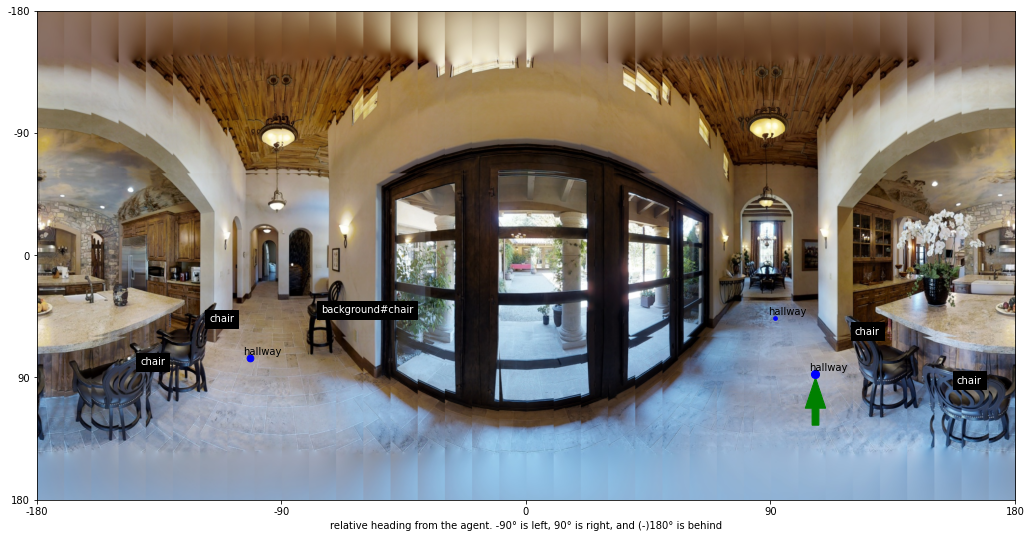

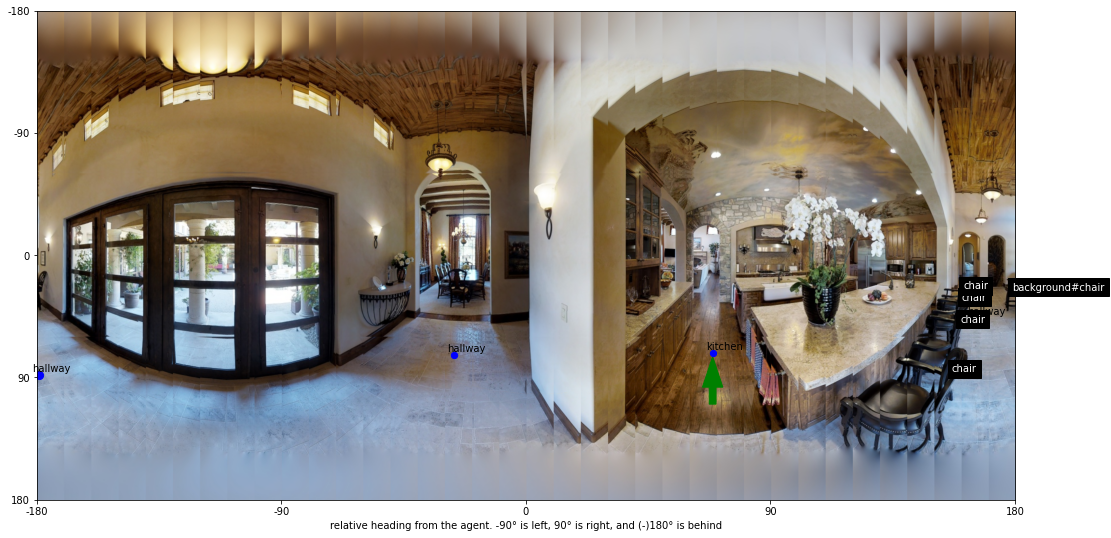

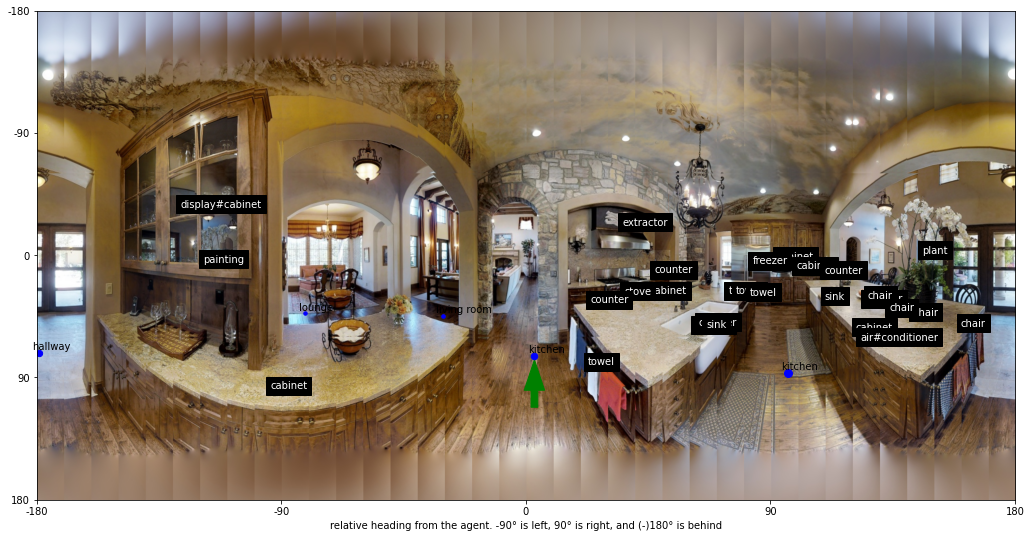

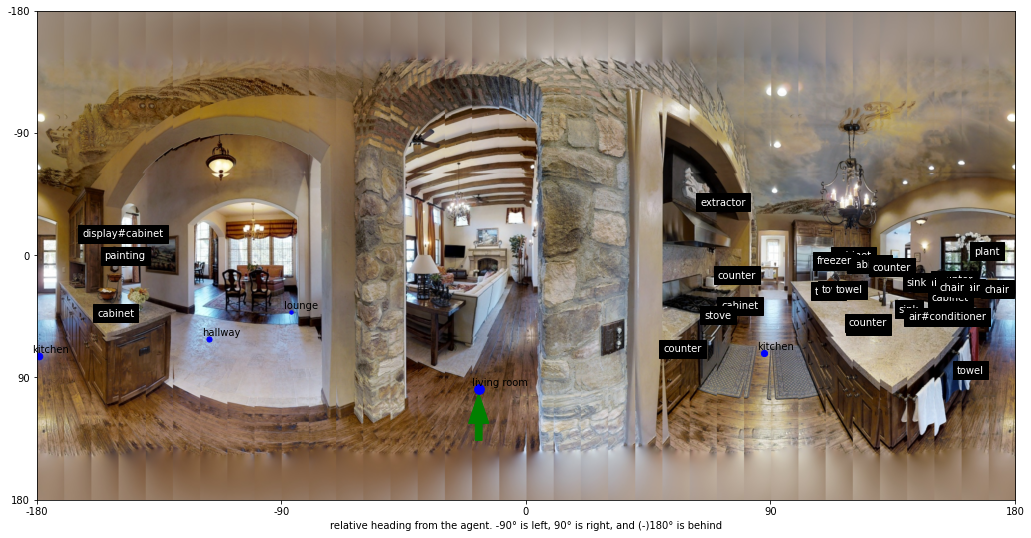

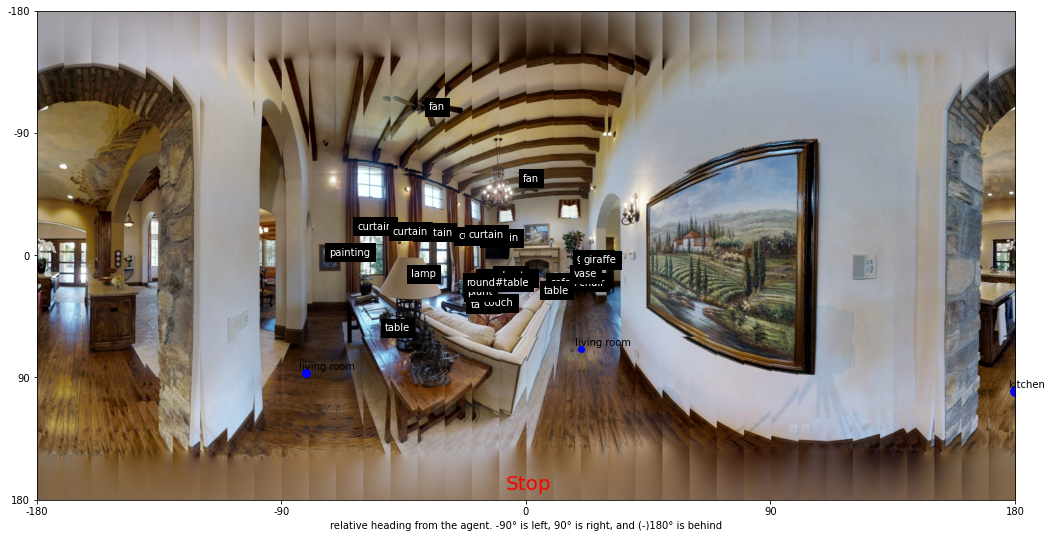

In [138]:
# Instructions
instructions = "- " + "\n\n- ".join(instruction_data['instructions'])
print("Human instructions from R2R :)")
print(instructions)

heading = initial_heading
craft_instructions = ['']
used_objects = []
for idx, viewpoint in enumerate(viewpoints_sequence):
    if idx < len(viewpoints_sequence) - 1:
        new_short_craft_instruction, heading, used_object = get_step_information_and_show_panorama(
            scan, viewpoint, heading, viewpoints_sequence[idx + 1], metadata, viewpoints_information, used_objects
        )
    else:
        new_short_craft_instruction, heading, used_object = get_step_information_and_show_panorama(
            scan, viewpoint, heading, viewpoints_sequence[idx], metadata, viewpoints_information, used_objects
        )
        plt.text(2880 // 2 - 60, 1440 - 30, 'Stop', fontsize=20, color='r') # Stop
            
    if used_object:
        used_objects.append(used_object['name'])
    
    new_crafted_atomic_instruction_different_as_last = new_short_craft_instruction != craft_instructions[-1]
    if new_short_craft_instruction and new_crafted_atomic_instruction_different_as_last:
        craft_instructions.append(new_short_craft_instruction)

complete_craft_instruction = ". ".join([x for x in craft_instructions if x])

print("\n\n\nCrafted instruction based on rules :)")
print(f"- {complete_craft_instruction}")